# Linear Mixed Effects Models

In linear mixed effects models, we wish to model a linear relationship for data points with inputs of varying type, categorized into subgroups, and associated to a continuous output.

We demonstrate with an example in Edward. A webpage version is available 
[here](http://edwardlib.org/tutorials/linear-mixed-effects-models).

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Normal

plt.style.use('ggplot')
%matplotlib inline

ed.set_seed(42)

## Data

We use the $\texttt{InstEval}$ dataset located [here](https://github.com/blei-lab/edward/blob/master/examples/data/insteval.csv). It's a dataset of instructor evaluation ratings where our inputs include categories such as $\texttt{students}$ and $\texttt{departments}$, while our observed variable is the actual rating.

In [2]:
# DATA
# s - students - 1:2972
# d - instructors - codes that need to be remapped
# dept also needs to be remapped
data = pd.read_csv('../../examples/data/insteval.csv')
data['dcodes'] = data['d'].astype('category').cat.codes
data['deptcodes'] = data['dept'].astype('category').cat.codes
data['s'] = data['s'] - 1

train = data.sample(frac=0.8)
test = data.drop(train.index)

train.head()

,Unnamed: 0,s,d,studage,lectage,service,dept,y,dcodes,deptcodes
20978,20979,846,314,4,2,0,11,4,159,10
73393,73394,2971,110,4,1,1,3,4,57,2
58879,58880,2381,1780,2,2,1,11,1,938,10
23264,23265,939,363,4,4,1,6,3,187,5
1959,1960,77,1699,6,5,0,15,3,896,13


In [3]:
s_train = train['s'].values.astype(int)
d_train = train['dcodes'].values.astype(int)
dept_train = train['deptcodes'].values.astype(int)
y_train = train['y'].values.astype(float)
service_train = train['service'].values.astype(int)
n_obs_train = train.shape[0]
service_train.shape = [n_obs_train, 1]


s_test = test['s'].values.astype(int)
d_test = test['dcodes'].values.astype(int)
dept_test = test['deptcodes'].values.astype(int)
y_test = test['y'].values.astype(float)
service_test = test['service'].values.astype(int)
n_obs_test = test.shape[0]
service_test.shape = [n_obs_test, 1]

In [4]:
n_s = 2972
n_d = 1128
n_dept = 14
n_obs = train.shape[0]

## Model

The main reason we use a mixed model rather than regular linear regression is because we cannot make the independence assumption. Rather, our observations come from sets of groups which can different slopes and intercepts.

For example:
* The observations from a single student are not independent of each other. Rather, some students may systematically give low (or high) lecture ratings.
* The observations of a single teachers are not independent from one another. We'd expect good teachers to get generally good ratings and bad teachers to get generally bad ratings.
* The observations of a department are not independent from one another. One department may generally have dry material and thus be rated lower than others.

Normal linear regression takes the form $$ y = X\beta + \epsilon $$ where $X$ corresponds to fixed effects with coefficients $\beta$.

However, our linear mixed model effects will add a new term, $Z\eta$, where $Z$ corresponds to random effects with coefficients $\eta$. Thus, our model now takes the form $$ y = X\beta + Z\eta + \epsilon $$ Our goal will be to infer both $\beta$ and $\eta$.

This obviously brings about the question on what is the difference between fixed variables $X$ and random variables $Z$. A fixed variable has a fixed set of categories, while random variables don't. This is better illustrated below with our example.

Our 'fixed' effect for this dataset is $\texttt{service}$, which is a binary variable corresponding to whether the lecture belongs to the lecturer's main department or not. No matter how much additional data we use, it can only take on the values of $0$ and $1$.

On the other hand, our 'random' effects are the categories of $\texttt{students}$, $\texttt{teachers}$, and $\texttt{departments}$. Given more data, we might be looking at new students, teachers, or departments. For example, we are not required to use the Statistics Department ratings in our model. But, we have the flexibility to do so.

Note that all random variables are Normal distributions centered around the origin. This means our mean is captured by $X\beta$, while $Z\eta$ encapsulates the deviation (e.g. Instructor #54 is rated 1.4 points higher than the mean).

Therefore, given the variables corresponding to $\texttt{students}$, $\texttt{teachers}$, $\texttt{departments}$, and $\texttt{service}$, we want to predict the rating given for the lecturer. Once we make te mixed effects' distinction, we can summarize our model as

$$y \sim 1 + (1|\texttt{students}) + (1|\texttt{instructor}) + \texttt{service} + (1|\texttt{dept})$$ where (1|x) denotes that x is a random effect, not fixed. This syntax is taken from R's 'lme4' package.

For the code below, we denote:
* $\texttt{students}$ as $\texttt{s}$
* $\texttt{instructors}$ as $\texttt{d}$
* $\texttt{departments}$ as $\texttt{dept}$
* $\texttt{service}$ as $\texttt{service}$

In [5]:
# MODEL
service_X = tf.placeholder(tf.float32, [n_obs, 1])

lnvar_s = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
lnvar_d = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
lnvar_dept = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

sigma_s = tf.sqrt(tf.exp(lnvar_s))
sigma_d = tf.sqrt(tf.exp(lnvar_d))
sigma_dept = tf.sqrt(tf.exp(lnvar_dept))

mu = Normal(mu=tf.zeros(1), sigma=tf.ones(1))
service = Normal(mu=tf.zeros(1), sigma=tf.ones(1))

eta_s = Normal(mu=tf.zeros(n_s), sigma=sigma_s * tf.ones(n_s))
eta_d = Normal(mu=tf.zeros(n_d), sigma=sigma_d * tf.ones(n_d))
eta_dept = Normal(mu=tf.zeros(n_dept), sigma=sigma_dept * tf.ones(n_dept))

yhat = tf.gather(eta_s, s_train) + \
    tf.gather(eta_d, d_train) + \
    tf.gather(eta_dept, dept_train) + \
    mu + ed.dot(service_X, service)
y = Normal(mu=yhat, sigma=tf.ones(n_obs))

## Inference

We'll use an inference method to estimate the effects of each category. First, we set up our inference variables below.

In [6]:
# INFERENCE
def make_normal(n):
  var = Normal(
      mu=tf.Variable(tf.random_normal([n])),
      sigma=tf.nn.softplus(tf.Variable(tf.random_normal([n]))))
  return var


q_eta_s = make_normal(n_s)
q_eta_d = make_normal(n_d)
q_eta_dept = make_normal(n_dept)

qlnvar_s = make_normal(1)
qlnvar_d = make_normal(1)
qlnvar_dept = make_normal(1)

qmu = make_normal(1)
qservice = make_normal(1)

params_dict = {
    mu: qmu,
    service: qservice,
    lnvar_s: qlnvar_s,
    lnvar_d: qlnvar_d,
    lnvar_dept: qlnvar_dept,
    eta_s: q_eta_s,
    eta_d: q_eta_d,
    eta_dept: q_eta_dept
}
data_dict = {y: y_train, service_X: service_train}

Now, we can use an inference algorithm. For this example, we minimize the $\text{KL}(q\|p)$ divergence measure.

In [7]:
inference = ed.KLqp(params_dict, data_dict)
inference.initialize(n_print=5, n_iter=50)

init = tf.global_variables_initializer()
init.run()

In [8]:
qs_mean = q_eta_s.mean()
qd_mean = q_eta_d.mean()
qdept_mean = q_eta_dept.mean()
qmu_mean = qmu.mean()
qservice_mean = qservice.mean()

service_X_test = tf.placeholder(tf.float32, [n_obs_test, 1])
yhat_test = tf.gather(qs_mean, s_test) + \
    tf.gather(qd_mean, d_test) + \
    tf.gather(qd_mean, dept_test) + \
    qmu_mean + ed.dot(service_X_test, qservice_mean)


for t in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  yhat_vals = yhat_test.eval(feed_dict={service_X_test: service_test})

Iteration  1 [  2%]: Loss = 467542.062
Iteration  5 [ 10%]: Loss = 311315.062
Iteration 10 [ 20%]: Loss = 195841.672
Iteration 15 [ 30%]: Loss = 240172.641
Iteration 20 [ 40%]: Loss = 147557.344
Iteration 25 [ 50%]: Loss = 187295.328
Iteration 30 [ 60%]: Loss = 186498.828
Iteration 35 [ 70%]: Loss = 120190.969
Iteration 40 [ 80%]: Loss = 111290.242
Iteration 45 [ 90%]: Loss = 128330.508
Iteration 50 [100%]: Loss = 111525.680


## Criticism

One way to visually critique our model is to plot the residual, i.e. the difference between the predicted value and the observed value.

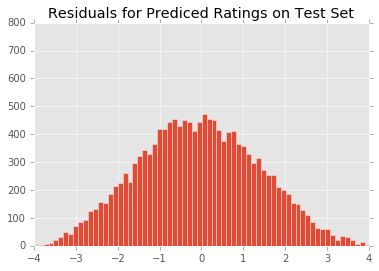

In [9]:
plt.title("Residuals for Prediced Ratings on Test Set")
plt.xlim(-4, 4)
plt.ylim(0, 800)
plt.hist(yhat_vals - y_test, 75)
plt.show()

Here, we see that the residuals have Normal error with mean around 0.